# Dataset

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class GAN_Dataset(Dataset):
    def __init__(self, data, ir_data, new_height, new_width):
        '''
        data - train data path
        '''
        self.train_data = data
        self.train_ir_data = ir_data
        self.new_height = new_height
        self.new_width = new_width
        
        self.images = sorted(os.listdir(self.train_data))
        self.irs = sorted(os.listdir(self.train_ir_data))
        
    def __len__(self):
        
        return len(self.images)
        
    def __getitem__(self,idx):
        
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        #img = img.convert('L')
        img = img.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        img = resize(img)
        trans = T.ToTensor()
        img = trans(img)
        
        ir_name = os.path.join(self.train_ir_data, self.irs[idx])
        ir = Image.open(ir_name)
        ir = ir.convert('L')
        ir = ir.convert('RGB')
        resize = T.Resize((self.new_height, self.new_width))
        ir = resize(ir)
        trans = T.ToTensor()
        ir = trans(ir)

        return img, ir

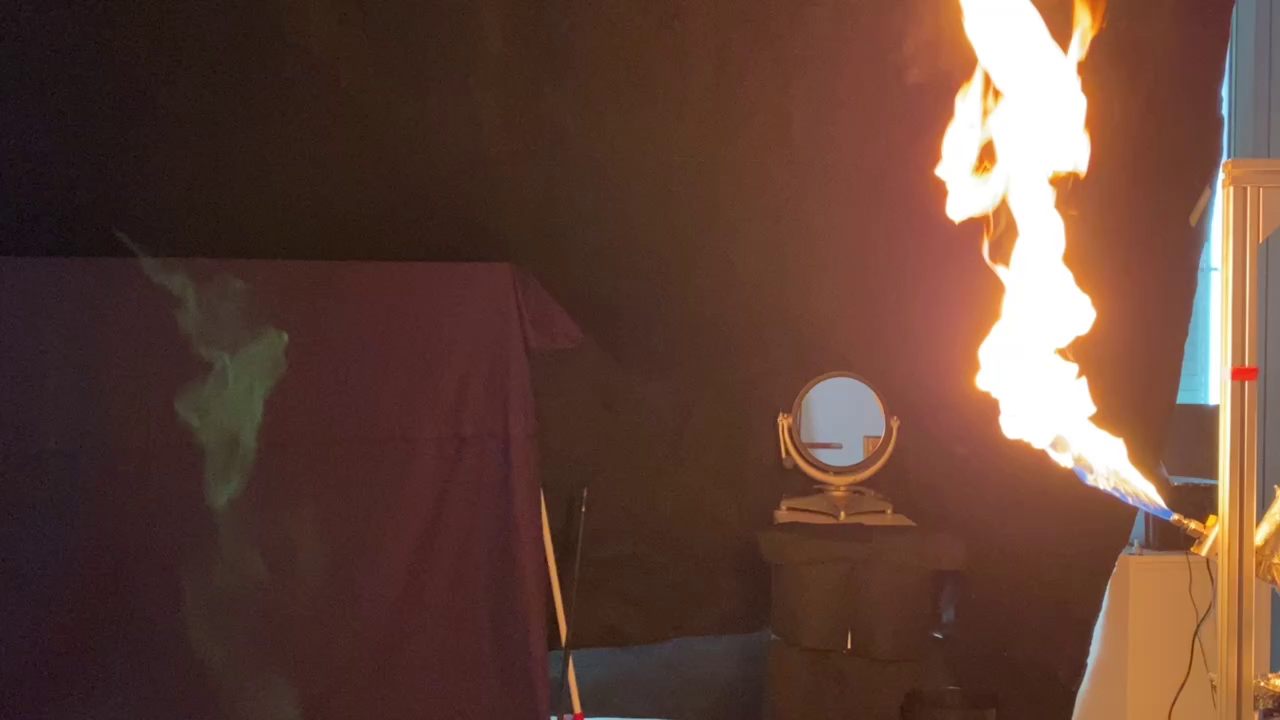

In [3]:
example_img = Image.open('Visible_match/0000.png')
example_img

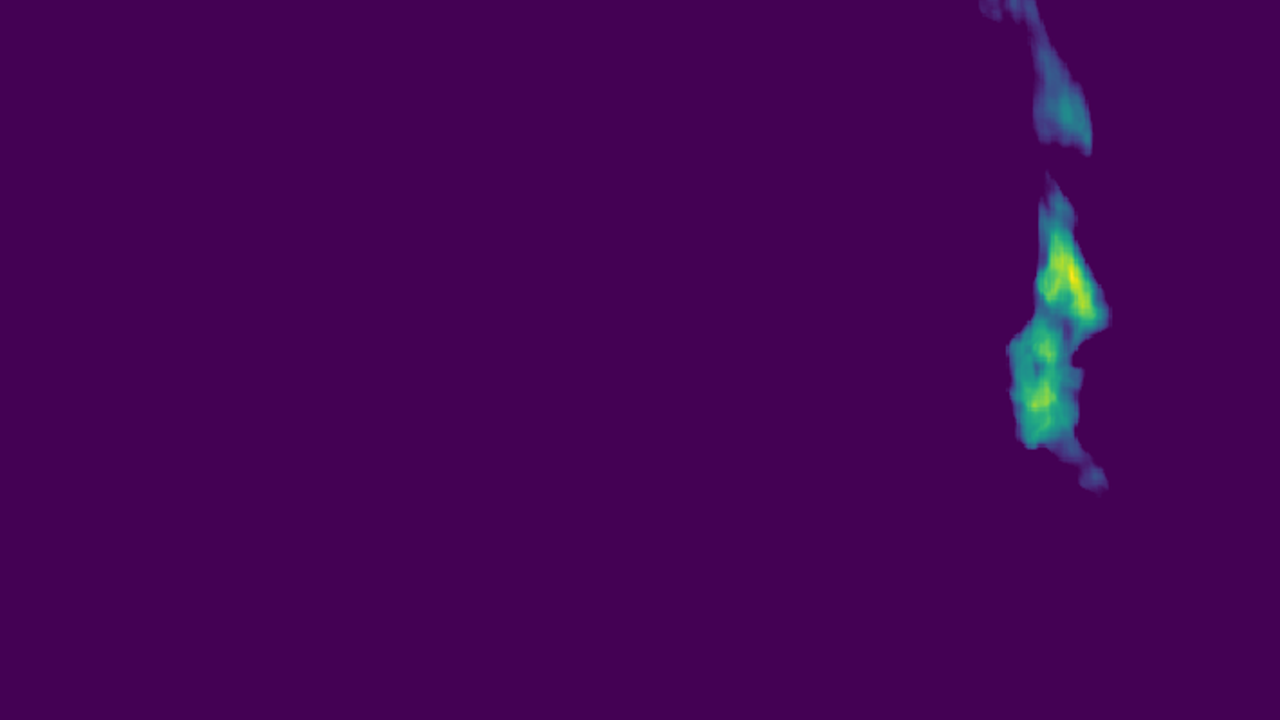

In [4]:
example_img = Image.open('IR_match_modified/00000076.png')
example_img

Full size 104
Train size:  66
Test size:  21
Val size:  17


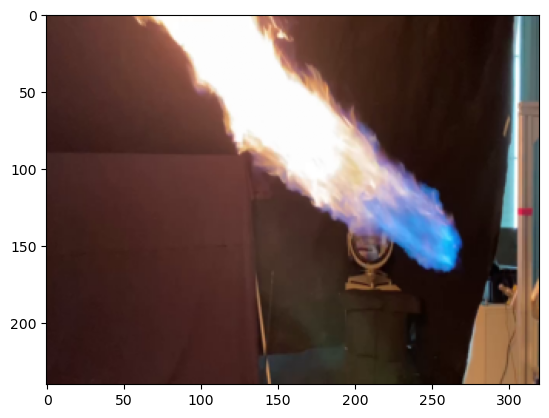

In [5]:
IMG_DIR = r"C:\Users\egard\Desktop\Github\Visible_match"
IR_DIR = r"C:\Users\egard\Desktop\Github\IR_match_modified"
full_dataset = GAN_Dataset(IMG_DIR,
                           IR_DIR,
                              240,
                              320)

batch_size = 5
torch.manual_seed(77)

train_size = int(len(full_dataset)*0.8)
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_size = int(len(train_dataset)*0.8)
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)

print('Full size', len(full_dataset))
print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))
print('Val size: ', len(val_dataset))

imgs, irs = next(iter(train_loader))

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(imgs[0]))

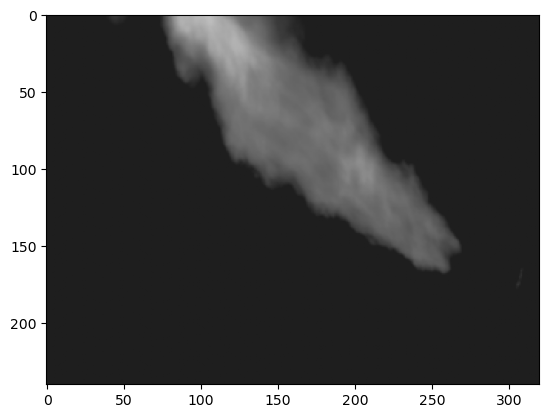

In [6]:
imshow(torchvision.utils.make_grid(irs[0]))

# Deep Learning Model

## GAN MODEL

## Generator

In [7]:
import torch.nn as nn

In [8]:
#Ma et al G2
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
                nn.Conv2d(6, 256, kernel_size = 5, stride = (1, 1), padding = 2),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
                
                nn.Conv2d(256, 128, kernel_size = 5, stride = (1, 1), padding = 2),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
            
                nn.Conv2d(128, 64, kernel_size = 3, stride = (1, 1), padding = 1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
            
                nn.Conv2d(64, 32, kernel_size = 3, stride = (1, 1), padding = 1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(),
            
                nn.Conv2d(32, 3, kernel_size = 1, stride = (1, 1), padding = 0),
                nn.Tanh(),
        )
    def forward(self, x):
        return self.generator(x)

## Discriminator

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.LeakyReLU(),
            
                nn.Conv2d(32, 64, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(),
            
                nn.Conv2d(64, 128, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(),
            
                nn.Conv2d(128, 256, kernel_size = 3, stride = (2, 2), padding = 'valid'),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(),
            
                nn.Flatten(),
                
                nn.Linear(256 * 14 * 19, 1)
        )
    def forward(self, x):
        return self.discriminator(x)

## Loss Functions

In [10]:
import torch.nn.functional as F

def gradient(img):
    filt = torch.tensor([
     [[[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]],
     [[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]],
     [[0.,1.,0.],[1.,-4.,1.],[0.,1.,0.]]]])
    
    filt = filt.to(device = device)
    img  = img.to(device = device)
    
    grad = F.conv2d(img, filt, stride=1, padding=1).cpu().detach().numpy()
    return grad


In [11]:
from numpy import linalg as LA
class Loss_G(nn.Module):
    def __init__(self, xi=0):
        super(Loss_G, self).__init__()
        self.xi = xi

    def forward(self, disc_out_g, ir_in, rgb_in, out_g):
        g_loss_1 = torch.mean((disc_out_g - ((torch.rand(rgb_in.shape[0], 1) * 0.5) + 0.7))**2)
        g_loss_2 = (1/(out_g.shape[2]*out_g.shape[3])) * (np.mean((   LA.norm((out_g - ir_in).cpu().detach().numpy())   )**2) + (self.xi * np.mean( ( LA.norm( (gradient(out_g) - gradient(rgb_in))) )**2)))
        total_loss = (g_loss_1) + 100*(g_loss_2)
        return total_loss

In [12]:
class Loss_D(nn.Module):
    def __init__(self):
        super(Loss_D, self).__init__()

    def forward(self, rgb_in, out_g):
        rgb_loss = torch.mean(torch.square(rgb_in - ((torch.rand(rgb_in.shape[0], 1) * 0.5) + 0.7)   ))

        g2_loss = torch.mean(torch.square(out_g - (torch.rand(rgb_in.shape[0], 1) * 0.3)))

        total_loss = rgb_loss + g2_loss

        return total_loss

# Training

In [13]:
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import warnings
import sys
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
torch.cuda.empty_cache()

In [14]:
def train(generator, discriminator, loss_fn_g, loss_fn_d, lr, epochs, train_data, val_data, test_data, batch_size):
    optimizer_g = optim.Adam(generator.parameters(), lr =  lr)
    optimizer_d = optim.Adam(discriminator.parameters(), lr =  lr)
    scaler_g  = torch.cuda.amp.GradScaler()
    scaler_d  = torch.cuda.amp.GradScaler()
    lst_loss_g = []
    lst_loss_d = []
    mean_loss_g = 0
    mean_loss_d = 0
    lst_mean_loss_g = []
    lst_mean_loss_d = []
    val_lst_loss_g = []
    val_lst_loss_d = []
    val_mean_loss_g = 0
    val_mean_loss_d = 0
    val_lst_mean_loss_g = []
    val_lst_mean_loss_d = []
    test_lst_loss_g = []
    test_lst_loss_d = []
    test_mean_loss_g = 0
    test_mean_loss_d = 0
    test_lst_mean_loss_g = []
    test_lst_mean_loss_d = []
    
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        loop = tqdm(train_data)
        for mb, (visible, ir) in enumerate(loop, start = 1):
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.cuda.amp.autocast():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).to(device = device)
                loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).to(device = device)
        
            #Zero grad
            
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()
            
            #Backpropagation
            
            scaler_g.scale(loss_generator).backward(retain_graph=True)
            scaler_d.scale(loss_discriminator).backward()
            
            #Update Parameters
            scaler_g.step(optimizer_g)
            scaler_g.update()
            scaler_d.step(optimizer_d)
            scaler_d.update()
        
            loop.set_postfix(loss_g = loss_generator.item(), loss_d = loss_discriminator.item())
            
        lst_loss_g = []
        lst_loss_d = []
        for i, data in enumerate(train_data, 0):
            visible, ir = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                lst_loss_g.append(loss_generator)
                lst_loss_d.append(loss_discriminator)
                
        
        mean_loss_g = np.mean(lst_loss_g)
        lst_mean_loss_g.append(mean_loss_g)
        mean_loss_d = np.mean(lst_loss_d)
        lst_mean_loss_d.append(mean_loss_d)
        
        val_lst_loss_g = []
        val_lst_loss_d = []
        for i, data in enumerate(val_data, 0):
            visible, ir = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                val_loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                val_loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                val_lst_loss_g.append(val_loss_generator)
                val_lst_loss_d.append(val_loss_discriminator)
                
        
        val_mean_loss_g = np.mean(val_lst_loss_g)
        val_lst_mean_loss_g.append(val_mean_loss_g)
        val_mean_loss_d = np.mean(val_lst_loss_d)
        val_lst_mean_loss_d.append(val_mean_loss_d)
        
        test_lst_loss_g = []
        test_lst_loss_d = []
        for i, data in enumerate(test_data, 0):
            visible, ir = data
            visible = visible.to(device = device)
            ir = ir.to(device = device)
            with torch.no_grad():
                
                generator_input = torch.cat([visible,ir],dim = 1).to(device = device)
                generator_output = generator(generator_input)
                discriminator_output_generator = discriminator(generator_output)
                discriminator_output_visible = discriminator(visible)
                
                visible = visible.cpu()
                ir = ir.cpu()
                generator_output = generator_output.cpu()
                discriminator_output_generator = discriminator_output_generator.cpu()
                discriminator_output_visible = discriminator_output_visible.cpu()
                
                test_loss_generator = loss_fn_g(discriminator_output_generator, ir, visible, generator_output).cpu()
                test_loss_discriminator = loss_fn_d(discriminator_output_visible, discriminator_output_generator).cpu()
                
                test_lst_loss_g.append(test_loss_generator)
                test_lst_loss_d.append(test_loss_discriminator)
                
        
        test_mean_loss_g = np.mean(test_lst_loss_g)
        test_lst_mean_loss_g.append(test_mean_loss_g)
        test_mean_loss_d = np.mean(test_lst_loss_d)
        test_lst_mean_loss_d.append(test_mean_loss_d)

    ax = sns.lineplot(x = range(len(lst_mean_loss_g)), y = lst_mean_loss_g, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss_g)), y = val_lst_mean_loss_g, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss_g)), y = test_lst_mean_loss_g, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss Generator")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    
    ax = sns.lineplot(x = range(len(lst_mean_loss_d)), y = lst_mean_loss_d, label = "Train")
    ax = sns.lineplot(x = range(len(val_lst_mean_loss_d)), y = val_lst_mean_loss_d, label = "Validation")
    ax = sns.lineplot(x = range(len(test_lst_mean_loss_d)), y = test_lst_mean_loss_d, label = "Test")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss Discriminator")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Train Loss Generator: ", lst_mean_loss_g[-1])
    print("Validation Loss Generator: ", val_lst_mean_loss_g[-1])
    print("Test Loss Generator", test_lst_mean_loss_g[-1])
    print("Train Loss Discriminator: ", lst_mean_loss_d[-1])
    print("Validation Discriminator: ", val_lst_mean_loss_d[-1])
    print("Test Discriminator", test_lst_mean_loss_d[-1])
    
    
    return generator, discriminator, lst_mean_loss_g[-1], val_lst_mean_loss_g[-1], test_lst_mean_loss_g[-1], lst_mean_loss_d[-1], val_lst_mean_loss_d[-1], test_lst_mean_loss_d[-1]

Epoch:  1


100%|████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.21it/s, loss_d=7.96, loss_g=33.4]


Epoch:  2


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.263, loss_g=30.5]


Epoch:  3


100%|███████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s, loss_d=0.314, loss_g=27.2]


Epoch:  4


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.373, loss_g=24.9]


Epoch:  5


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, loss_d=1.5, loss_g=29]


Epoch:  6


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, loss_d=0.294, loss_g=29.7]


Epoch:  7


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.0547, loss_g=30]


Epoch:  8


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=8.53, loss_g=32.4]


Epoch:  9


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.19, loss_g=36.3]


Epoch:  10


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.451, loss_g=34.3]


Epoch:  11


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=8.61, loss_g=36.4]


Epoch:  12


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.0719, loss_g=31]


Epoch:  13


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=2.15, loss_g=32.9]


Epoch:  14


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=3.97, loss_g=34.4]


Epoch:  15


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.6, loss_g=33.6]


Epoch:  16


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.619, loss_g=29.7]


Epoch:  17


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.62, loss_g=32.4]


Epoch:  18


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.77, loss_g=28.3]


Epoch:  19


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.32, loss_g=26.3]


Epoch:  20


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.395, loss_g=34.6]


Epoch:  21


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=5.2, loss_g=31.8]


Epoch:  22


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.08, loss_g=36.4]


Epoch:  23


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=4.66, loss_g=36.6]


Epoch:  24


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=7.71, loss_g=44.2]


Epoch:  25


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=8.2, loss_g=36.7]


Epoch:  26


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=2.49, loss_g=30.7]


Epoch:  27


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.282, loss_g=34.3]


Epoch:  28


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=8.03, loss_g=31]


Epoch:  29


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=2.17, loss_g=35.6]


Epoch:  30


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.552, loss_g=33.2]


Epoch:  31


100%|██████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.0284, loss_g=34.6]


Epoch:  32


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.745, loss_g=32.3]


Epoch:  33


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.541, loss_g=27.2]


Epoch:  34


100%|███████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.26it/s, loss_d=0.763, loss_g=31.1]


Epoch:  35


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.707, loss_g=32.2]


Epoch:  36


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=0.982, loss_g=32.3]


Epoch:  37


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=4.21, loss_g=27.8]


Epoch:  38


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=1.24, loss_g=25.9]


Epoch:  39


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.465, loss_g=33.7]


Epoch:  40


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.805, loss_g=32.4]


Epoch:  41


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=7.52, loss_g=27.7]


Epoch:  42


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=1.29, loss_g=34.7]


Epoch:  43


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.614, loss_g=34.5]


Epoch:  44


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.44, loss_g=36]


Epoch:  45


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.658, loss_g=36.1]


Epoch:  46


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=20.5, loss_g=31.5]


Epoch:  47


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=0.319, loss_g=33.5]


Epoch:  48


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.615, loss_g=32.8]


Epoch:  49


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.41, loss_g=33.4]


Epoch:  50


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=15.2, loss_g=31.9]


Epoch:  51


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=2.18, loss_g=32]


Epoch:  52


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.44, loss_g=32.9]


Epoch:  53


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.2, loss_g=34]


Epoch:  54


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.6, loss_g=30.7]


Epoch:  55


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=11.5, loss_g=28.9]


Epoch:  56


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=6.38, loss_g=35.3]


Epoch:  57


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=1.26, loss_g=35.1]


Epoch:  58


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=0.543, loss_g=32.5]


Epoch:  59


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.493, loss_g=32.3]


Epoch:  60


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, loss_d=0.67, loss_g=32.1]


Epoch:  61


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=0.748, loss_g=31.5]


Epoch:  62


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=1.71, loss_g=34.2]


Epoch:  63


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.87, loss_g=32.5]


Epoch:  64


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=4.25, loss_g=30.6]


Epoch:  65


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=1.86, loss_g=33.4]


Epoch:  66


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.596, loss_g=33]


Epoch:  67


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.7, loss_g=33.1]


Epoch:  68


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=12.9, loss_g=30.7]


Epoch:  69


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.852, loss_g=33]


Epoch:  70


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.504, loss_g=33.6]


Epoch:  71


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.964, loss_g=33.3]


Epoch:  72


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.75, loss_g=33.5]


Epoch:  73


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=1.32, loss_g=29.7]


Epoch:  74


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.45, loss_g=33.1]


Epoch:  75


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=41.5, loss_g=41.1]


Epoch:  76


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.745, loss_g=29.9]


Epoch:  77


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=37.7, loss_g=44]


Epoch:  78


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.274, loss_g=28.2]


Epoch:  79


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=47.1, loss_g=41.8]


Epoch:  80


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=2.23, loss_g=34.4]


Epoch:  81


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=1.52, loss_g=32.7]


Epoch:  82


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.42, loss_g=31.6]


Epoch:  83


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.01, loss_g=33.4]


Epoch:  84


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.0228, loss_g=32.6]


Epoch:  85


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.621, loss_g=33]


Epoch:  86


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=7.33, loss_g=30]


Epoch:  87


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.41, loss_g=28.6]


Epoch:  88


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.906, loss_g=30.6]


Epoch:  89


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=33.5, loss_g=48.5]


Epoch:  90


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.449, loss_g=27.2]


Epoch:  91


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.598, loss_g=27.6]


Epoch:  92


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.923, loss_g=27.7]


Epoch:  93


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=1.15, loss_g=27.9]


Epoch:  94


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.216, loss_g=26.7]


Epoch:  95


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=0.859, loss_g=28.9]


Epoch:  96


100%|██████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, loss_d=1.32, loss_g=29]


Epoch:  97


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=0.775, loss_g=28.5]


Epoch:  98


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, loss_d=0.556, loss_g=28.7]


Epoch:  99


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.77, loss_g=20.5]


Epoch:  100


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.367, loss_g=28.5]


Epoch:  101


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=37.1, loss_g=30.5]


Epoch:  102


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.167, loss_g=32.3]


Epoch:  103


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.58, loss_g=28.7]


Epoch:  104


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.1, loss_g=27.4]


Epoch:  105


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.73, loss_g=32.2]


Epoch:  106


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.94, loss_g=30.9]


Epoch:  107


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=2.5, loss_g=31.3]


Epoch:  108


100%|██████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, loss_d=1.85, loss_g=34]


Epoch:  109


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=2.03, loss_g=31.9]


Epoch:  110


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=0.92, loss_g=27.1]


Epoch:  111


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=0.78, loss_g=32.8]


Epoch:  112


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=2.01, loss_g=30.1]


Epoch:  113


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=1.34, loss_g=31.3]


Epoch:  114


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.395, loss_g=21.8]


Epoch:  115


100%|█████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, loss_d=0.676, loss_g=19]


Epoch:  116


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.435, loss_g=31.4]


Epoch:  117


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.9, loss_g=22.4]


Epoch:  118


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=0.429, loss_g=32.4]


Epoch:  119


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=20.6, loss_g=30.7]


Epoch:  120


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=20.7, loss_g=40.3]


Epoch:  121


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.18, loss_g=31]


Epoch:  122


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.565, loss_g=35.5]


Epoch:  123


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=1.46, loss_g=30]


Epoch:  124


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.36, loss_g=36.4]


Epoch:  125


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.589, loss_g=30.7]


Epoch:  126


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.199, loss_g=32.5]


Epoch:  127


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.538, loss_g=26.6]


Epoch:  128


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.22, loss_g=38.4]


Epoch:  129


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=1.3, loss_g=38.4]


Epoch:  130


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.06, loss_g=30.5]


Epoch:  131


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.665, loss_g=30.5]


Epoch:  132


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=0.99, loss_g=36.4]


Epoch:  133


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=0.442, loss_g=28.2]


Epoch:  134


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.735, loss_g=35.3]


Epoch:  135


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.608, loss_g=36.4]


Epoch:  136


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.736, loss_g=32.5]


Epoch:  137


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.23, loss_g=36]


Epoch:  138


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.766, loss_g=27.9]


Epoch:  139


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.67, loss_g=36.5]


Epoch:  140


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.421, loss_g=35.5]


Epoch:  141


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=5.59, loss_g=27.4]


Epoch:  142


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.631, loss_g=36.4]


Epoch:  143


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.649, loss_g=33.3]


Epoch:  144


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.856, loss_g=33.4]


Epoch:  145


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.6, loss_g=27.2]


Epoch:  146


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.39, loss_g=36]


Epoch:  147


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.27, loss_g=25.7]


Epoch:  148


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.864, loss_g=36.6]


Epoch:  149


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.357, loss_g=38.4]


Epoch:  150


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.58, loss_g=38.4]


Epoch:  151


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.31, loss_g=27.1]


Epoch:  152


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.01, loss_g=25.8]


Epoch:  153


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.629, loss_g=34.1]


Epoch:  154


100%|██████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=0.0701, loss_g=28.8]


Epoch:  155


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.62, loss_g=36.5]


Epoch:  156


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.527, loss_g=37.7]


Epoch:  157


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.11, loss_g=27.4]


Epoch:  158


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.71, loss_g=28.3]


Epoch:  159


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=0.785, loss_g=34.4]


Epoch:  160


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.15, loss_g=36.7]


Epoch:  161


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.58, loss_g=36.3]


Epoch:  162


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.446, loss_g=29]


Epoch:  163


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.12, loss_g=31.2]


Epoch:  164


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.475, loss_g=28.8]


Epoch:  165


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.47, loss_g=27.5]


Epoch:  166


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.981, loss_g=36.7]


Epoch:  167


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.45, loss_g=29.1]


Epoch:  168


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.126, loss_g=27.7]


Epoch:  169


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.286, loss_g=33.9]


Epoch:  170


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.415, loss_g=35.4]


Epoch:  171


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.58, loss_g=34.3]


Epoch:  172


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.25, loss_g=32.4]


Epoch:  173


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.374, loss_g=35.4]


Epoch:  174


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.719, loss_g=35.3]


Epoch:  175


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.749, loss_g=37.7]


Epoch:  176


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.47, loss_g=32.3]


Epoch:  177


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.748, loss_g=34.1]


Epoch:  178


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.968, loss_g=34]


Epoch:  179


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.606, loss_g=36.3]


Epoch:  180


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.779, loss_g=34.6]


Epoch:  181


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.527, loss_g=36]


Epoch:  182


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.25, loss_g=27.1]


Epoch:  183


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.559, loss_g=33.3]


Epoch:  184


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.633, loss_g=35.5]


Epoch:  185


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.564, loss_g=35.3]


Epoch:  186


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.01, loss_g=33.2]


Epoch:  187


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.549, loss_g=27.1]


Epoch:  188


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.776, loss_g=36.4]


Epoch:  189


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.968, loss_g=36.2]


Epoch:  190


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.51, loss_g=27.2]


Epoch:  191


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=4.13, loss_g=30.7]


Epoch:  192


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.845, loss_g=35.3]


Epoch:  193


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.05, loss_g=33.5]


Epoch:  194


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=1.99, loss_g=29.4]


Epoch:  195


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.439, loss_g=35]


Epoch:  196


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.82, loss_g=36]


Epoch:  197


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.879, loss_g=35.8]


Epoch:  198


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.614, loss_g=33.9]


Epoch:  199


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=0.815, loss_g=32]


Epoch:  200


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.599, loss_g=35.2]


Epoch:  201


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.595, loss_g=32.2]


Epoch:  202


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=1.13, loss_g=27.2]


Epoch:  203


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.736, loss_g=35.7]


Epoch:  204


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.581, loss_g=37.1]


Epoch:  205


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.388, loss_g=28.6]


Epoch:  206


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.375, loss_g=33.5]


Epoch:  207


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.831, loss_g=33.2]


Epoch:  208


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.573, loss_g=26.9]


Epoch:  209


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.988, loss_g=35.5]


Epoch:  210


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.817, loss_g=35.3]


Epoch:  211


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.831, loss_g=31.8]


Epoch:  212


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.426, loss_g=34.2]


Epoch:  213


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.817, loss_g=36.2]


Epoch:  214


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.614, loss_g=35.4]


Epoch:  215


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.84, loss_g=29]


Epoch:  216


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.496, loss_g=28.6]


Epoch:  217


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.06, loss_g=36.1]


Epoch:  218


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.484, loss_g=33.4]


Epoch:  219


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.775, loss_g=34.2]


Epoch:  220


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.665, loss_g=26.2]


Epoch:  221


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.40it/s, loss_d=0.657, loss_g=35.2]


Epoch:  222


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.933, loss_g=25.4]


Epoch:  223


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.646, loss_g=35.9]


Epoch:  224


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.504, loss_g=34.9]


Epoch:  225


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.15, loss_g=26.2]


Epoch:  226


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.602, loss_g=27.6]


Epoch:  227


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.997, loss_g=35.1]


Epoch:  228


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.757, loss_g=36.2]


Epoch:  229


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.994, loss_g=36]


Epoch:  230


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.631, loss_g=36.4]


Epoch:  231


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.505, loss_g=34.8]


Epoch:  232


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.862, loss_g=33.5]


Epoch:  233


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.68, loss_g=26.7]


Epoch:  234


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.578, loss_g=27]


Epoch:  235


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.996, loss_g=36.7]


Epoch:  236


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.453, loss_g=33.6]


Epoch:  237


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.131, loss_g=25.6]


Epoch:  238


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.43, loss_g=26.3]


Epoch:  239


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.289, loss_g=27.4]


Epoch:  240


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=1.04, loss_g=36.3]


Epoch:  241


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.82, loss_g=34.4]


Epoch:  242


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.444, loss_g=37.4]


Epoch:  243


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.861, loss_g=33.2]


Epoch:  244


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=1.89, loss_g=26.1]


Epoch:  245


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=2.33, loss_g=27.2]


Epoch:  246


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.351, loss_g=34.1]


Epoch:  247


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.11, loss_g=26.3]


Epoch:  248


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.53, loss_g=34.2]


Epoch:  249


100%|██████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.31it/s, loss_d=1.61, loss_g=35]


Epoch:  250


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.909, loss_g=35.3]


Epoch:  251


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.08, loss_g=26.8]


Epoch:  252


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.153, loss_g=26.4]


Epoch:  253


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.869, loss_g=27.5]


Epoch:  254


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.691, loss_g=33.2]


Epoch:  255


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.16, loss_g=27.6]


Epoch:  256


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.675, loss_g=34.9]


Epoch:  257


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.52, loss_g=25.6]


Epoch:  258


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.377, loss_g=35.8]


Epoch:  259


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.745, loss_g=33.6]


Epoch:  260


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.623, loss_g=32.2]


Epoch:  261


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.5, loss_g=35.6]


Epoch:  262


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.1, loss_g=34.9]


Epoch:  263


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.222, loss_g=35.9]


Epoch:  264


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=0.51, loss_g=37.2]


Epoch:  265


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.99, loss_g=36.8]


Epoch:  266


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.97, loss_g=36.5]


Epoch:  267


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.717, loss_g=37]


Epoch:  268


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.08, loss_g=35.5]


Epoch:  269


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.388, loss_g=37.3]


Epoch:  270


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.48, loss_g=33.3]


Epoch:  271


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.502, loss_g=37.5]


Epoch:  272


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.738, loss_g=35.4]


Epoch:  273


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.682, loss_g=37.4]


Epoch:  274


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.64, loss_g=27.3]


Epoch:  275


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.43, loss_g=31.4]


Epoch:  276


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.843, loss_g=28.8]


Epoch:  277


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.294, loss_g=27.2]


Epoch:  278


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.392, loss_g=36]


Epoch:  279


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=2.53, loss_g=38.5]


Epoch:  280


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.749, loss_g=34]


Epoch:  281


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.772, loss_g=28.7]


Epoch:  282


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.13, loss_g=34.5]


Epoch:  283


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.645, loss_g=32.1]


Epoch:  284


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.959, loss_g=33.5]


Epoch:  285


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.44, loss_g=36.9]


Epoch:  286


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.999, loss_g=37.3]


Epoch:  287


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.341, loss_g=28.3]


Epoch:  288


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.772, loss_g=28.9]


Epoch:  289


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.961, loss_g=26.9]


Epoch:  290


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.587, loss_g=39.8]


Epoch:  291


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.11, loss_g=38.1]


Epoch:  292


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.206, loss_g=39.4]


Epoch:  293


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.87, loss_g=38.4]


Epoch:  294


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.647, loss_g=32.5]


Epoch:  295


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.693, loss_g=38.5]


Epoch:  296


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=1.01, loss_g=37.1]


Epoch:  297


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.28, loss_g=39.7]


Epoch:  298


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.48, loss_g=34.9]


Epoch:  299


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.89, loss_g=34.9]


Epoch:  300


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.512, loss_g=38.7]


Epoch:  301


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=7.19, loss_g=34.5]


Epoch:  302


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.88, loss_g=39.2]


Epoch:  303


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.85, loss_g=39.4]


Epoch:  304


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.533, loss_g=34.3]


Epoch:  305


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.27, loss_g=25.2]


Epoch:  306


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.65, loss_g=31.1]


Epoch:  307


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.17, loss_g=29.1]


Epoch:  308


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=1.19, loss_g=29.8]


Epoch:  309


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.04, loss_g=28.8]


Epoch:  310


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.72, loss_g=33.5]


Epoch:  311


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.908, loss_g=31.6]


Epoch:  312


100%|█████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=2, loss_g=32]


Epoch:  313


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.48, loss_g=23.5]


Epoch:  314


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.478, loss_g=21.4]


Epoch:  315


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.78, loss_g=33]


Epoch:  316


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.844, loss_g=25.6]


Epoch:  317


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.82, loss_g=33.3]


Epoch:  318


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.64, loss_g=26.5]


Epoch:  319


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=1.13, loss_g=33.7]


Epoch:  320


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.31, loss_g=31.5]


Epoch:  321


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.543, loss_g=21.5]


Epoch:  322


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.23, loss_g=31.1]


Epoch:  323


100%|███████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.4, loss_g=31]


Epoch:  324


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.884, loss_g=30.5]


Epoch:  325


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.487, loss_g=30.8]


Epoch:  326


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.623, loss_g=32.1]


Epoch:  327


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.759, loss_g=29.2]


Epoch:  328


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.49, loss_g=32.7]


Epoch:  329


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.851, loss_g=29.3]


Epoch:  330


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.82, loss_g=21.8]


Epoch:  331


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.804, loss_g=31.5]


Epoch:  332


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.938, loss_g=27.3]


Epoch:  333


100%|██████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.0631, loss_g=27.2]


Epoch:  334


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.953, loss_g=22.4]


Epoch:  335


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.221, loss_g=22.6]


Epoch:  336


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.971, loss_g=23.5]


Epoch:  337


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.78, loss_g=29.3]


Epoch:  338


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.13, loss_g=34.9]


Epoch:  339


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.25, loss_g=31.3]


Epoch:  340


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=2.95, loss_g=20.8]


Epoch:  341


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.24, loss_g=33.7]


Epoch:  342


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=33.7, loss_g=33.8]


Epoch:  343


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.62, loss_g=26.7]


Epoch:  344


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.575, loss_g=25.6]


Epoch:  345


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=5.71, loss_g=28.4]


Epoch:  346


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=12.2, loss_g=32.4]


Epoch:  347


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.6, loss_g=22.3]


Epoch:  348


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.14, loss_g=21.4]


Epoch:  349


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=5.71, loss_g=30.1]


Epoch:  350


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.398, loss_g=29.3]


Epoch:  351


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.944, loss_g=21.4]


Epoch:  352


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=1.26, loss_g=31.4]


Epoch:  353


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=8.97, loss_g=22.4]


Epoch:  354


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.28it/s, loss_d=0.285, loss_g=28.9]


Epoch:  355


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=1.46, loss_g=30.4]


Epoch:  356


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.847, loss_g=27.7]


Epoch:  357


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=2.21, loss_g=20.6]


Epoch:  358


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.514, loss_g=26.5]


Epoch:  359


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.571, loss_g=29.7]


Epoch:  360


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.371, loss_g=27.5]


Epoch:  361


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.392, loss_g=25.6]


Epoch:  362


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.63, loss_g=21.8]


Epoch:  363


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s, loss_d=3.31, loss_g=21.4]


Epoch:  364


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.484, loss_g=29.5]


Epoch:  365


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.466, loss_g=26.7]


Epoch:  366


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=11.3, loss_g=28.5]


Epoch:  367


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.456, loss_g=32.6]


Epoch:  368


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=14.3, loss_g=22.9]


Epoch:  369


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=1.5, loss_g=29.9]


Epoch:  370


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.99, loss_g=31.5]


Epoch:  371


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.54, loss_g=30.4]


Epoch:  372


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.55, loss_g=29.7]


Epoch:  373


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.39it/s, loss_d=0.828, loss_g=33.2]


Epoch:  374


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.304, loss_g=33.3]


Epoch:  375


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.955, loss_g=21.4]


Epoch:  376


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=17.1, loss_g=35]


Epoch:  377


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.777, loss_g=30.9]


Epoch:  378


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=1.09, loss_g=33.4]


Epoch:  379


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.709, loss_g=36.1]


Epoch:  380


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.453, loss_g=34.4]


Epoch:  381


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=3.91, loss_g=37.5]


Epoch:  382


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.97, loss_g=35.2]


Epoch:  383


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.03, loss_g=32.2]


Epoch:  384


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.02, loss_g=35.5]


Epoch:  385


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=64.7, loss_g=49.9]


Epoch:  386


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=28.9, loss_g=26.9]


Epoch:  387


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=0.639, loss_g=29.8]


Epoch:  388


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=23.3, loss_g=39.6]


Epoch:  389


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=36.7, loss_g=20.3]


Epoch:  390


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.3, loss_g=31.3]


Epoch:  391


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=84, loss_g=49.2]


Epoch:  392


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.78, loss_g=31.9]


Epoch:  393


100%|███████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=1.9, loss_g=36]


Epoch:  394


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=3.05, loss_g=29.4]


Epoch:  395


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.38it/s, loss_d=18.8, loss_g=22.6]


Epoch:  396


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.38, loss_g=34.1]


Epoch:  397


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=0.628, loss_g=31.1]


Epoch:  398


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.28, loss_g=36.9]


Epoch:  399


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.12, loss_g=34.7]


Epoch:  400


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.555, loss_g=31.4]


Epoch:  401


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.7, loss_g=30.9]


Epoch:  402


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.15, loss_g=33]


Epoch:  403


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.4, loss_g=29.3]


Epoch:  404


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.11, loss_g=35.9]


Epoch:  405


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.62, loss_g=33.1]


Epoch:  406


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.426, loss_g=34.8]


Epoch:  407


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.14, loss_g=32.9]


Epoch:  408


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.46, loss_g=31.8]


Epoch:  409


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=23.1, loss_g=29.9]


Epoch:  410


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=9.43, loss_g=23.2]


Epoch:  411


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.74, loss_g=36.8]


Epoch:  412


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=5.51, loss_g=28.4]


Epoch:  413


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.741, loss_g=35.4]


Epoch:  414


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.697, loss_g=33.3]


Epoch:  415


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.247, loss_g=35.9]


Epoch:  416


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.997, loss_g=34.8]


Epoch:  417


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=49.1, loss_g=26.4]


Epoch:  418


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=4.84, loss_g=33.8]


Epoch:  419


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=4.24, loss_g=34.6]


Epoch:  420


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.22, loss_g=33]


Epoch:  421


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=11.2, loss_g=25]


Epoch:  422


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=7.13, loss_g=18.9]


Epoch:  423


100%|██████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=31, loss_g=34.3]


Epoch:  424


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=6.27, loss_g=32.5]


Epoch:  425


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.45it/s, loss_d=10.2, loss_g=21.2]


Epoch:  426


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=1.1, loss_g=32.6]


Epoch:  427


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=0.148, loss_g=31.1]


Epoch:  428


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s, loss_d=0.669, loss_g=33.1]


Epoch:  429


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.38, loss_g=29.7]


Epoch:  430


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=1.02, loss_g=29.9]


Epoch:  431


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.733, loss_g=21.9]


Epoch:  432


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.78, loss_g=29.6]


Epoch:  433


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=1.47, loss_g=29.9]


Epoch:  434


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=21.3, loss_g=25.4]


Epoch:  435


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=2.58, loss_g=29.4]


Epoch:  436


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.58, loss_g=30.1]


Epoch:  437


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=3.58, loss_g=19.9]


Epoch:  438


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.502, loss_g=31.1]


Epoch:  439


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.22, loss_g=34.4]


Epoch:  440


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.906, loss_g=31.2]


Epoch:  441


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=3.24, loss_g=23.2]


Epoch:  442


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=0.832, loss_g=31.3]


Epoch:  443


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s, loss_d=0.737, loss_g=30.8]


Epoch:  444


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.728, loss_g=31.3]


Epoch:  445


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=0.888, loss_g=30.7]


Epoch:  446


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=8.04, loss_g=31.8]


Epoch:  447


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=1.47, loss_g=31.1]


Epoch:  448


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s, loss_d=10.4, loss_g=18.1]


Epoch:  449


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=1.47, loss_g=30.7]


Epoch:  450


100%|██████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.87, loss_g=32]


Epoch:  451


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, loss_d=0.366, loss_g=30.9]


Epoch:  452


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=0.471, loss_g=31.5]


Epoch:  453


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.61it/s, loss_d=1.04, loss_g=31.5]


Epoch:  454


100%|██████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.63it/s, loss_d=26.7, loss_g=19]


Epoch:  455


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.67it/s, loss_d=1.07, loss_g=33.3]


Epoch:  456


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, loss_d=0.71, loss_g=31.1]


Epoch:  457


100%|█████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=1.6, loss_g=32.6]


Epoch:  458


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, loss_d=0.948, loss_g=31.4]


Epoch:  459


100%|███████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, loss_d=0.904, loss_g=31.5]


Epoch:  460


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=1.77, loss_g=17.7]


Epoch:  461


100%|████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.65it/s, loss_d=5.63, loss_g=17.4]


Epoch:  462


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.44it/s, loss_d=2.13, loss_g=33.8]


Epoch:  463


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.41it/s, loss_d=0.487, loss_g=31.3]


Epoch:  464


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=1.75, loss_g=32.7]


Epoch:  465


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, loss_d=1.13, loss_g=31.9]


Epoch:  466


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=10.4, loss_g=18.1]


Epoch:  467


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=1.06, loss_g=31.3]


Epoch:  468


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=12.6, loss_g=26.9]


Epoch:  469


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.16, loss_g=32.1]


Epoch:  470


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.512, loss_g=32.4]


Epoch:  471


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.92, loss_g=27.1]


Epoch:  472


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.52it/s, loss_d=0.583, loss_g=32.7]


Epoch:  473


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.325, loss_g=31.3]


Epoch:  474


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.51it/s, loss_d=0.456, loss_g=31.6]


Epoch:  475


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=6.84, loss_g=16.5]


Epoch:  476


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=13.7, loss_g=19.4]


Epoch:  477


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=2.13, loss_g=27.5]


Epoch:  478


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=13.4, loss_g=19.4]


Epoch:  479


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s, loss_d=2.49, loss_g=17.2]


Epoch:  480


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=2.02, loss_g=31.2]


Epoch:  481


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=1.07, loss_g=32.9]


Epoch:  482


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.557, loss_g=32.1]


Epoch:  483


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.30it/s, loss_d=2.89, loss_g=22.7]


Epoch:  484


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.65, loss_g=29.5]


Epoch:  485


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.799, loss_g=34.4]


Epoch:  486


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=2.93, loss_g=27.2]


Epoch:  487


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=19.6, loss_g=17.9]


Epoch:  488


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.42it/s, loss_d=0.573, loss_g=31.8]


Epoch:  489


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=0.537, loss_g=33.2]


Epoch:  490


100%|███████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.2, loss_g=31]


Epoch:  491


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=1.2, loss_g=33.7]


Epoch:  492


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=13.4, loss_g=15.9]


Epoch:  493


100%|█████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s, loss_d=0.318, loss_g=31]


Epoch:  494


100%|███████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.37it/s, loss_d=0.604, loss_g=32.6]


Epoch:  495


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.47it/s, loss_d=0.611, loss_g=32.3]


Epoch:  496


100%|███████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.48it/s, loss_d=0.446, loss_g=33.1]


Epoch:  497


100%|████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.49it/s, loss_d=6.09, loss_g=18.9]


Epoch:  498


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s, loss_d=6.46, loss_g=17.5]


Epoch:  499


100%|█████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.33it/s, loss_d=1.4, loss_g=33.9]


Epoch:  500


100%|████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.35it/s, loss_d=2.45, loss_g=27.8]


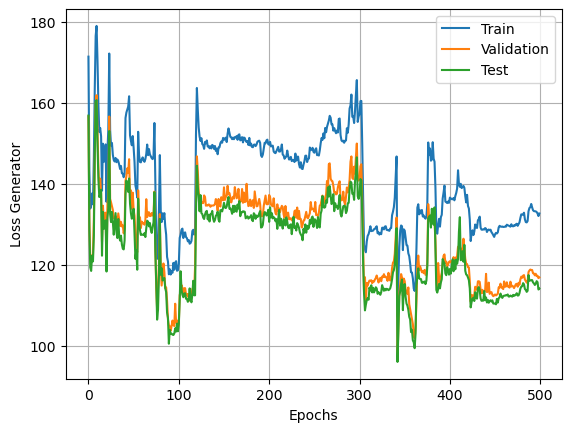

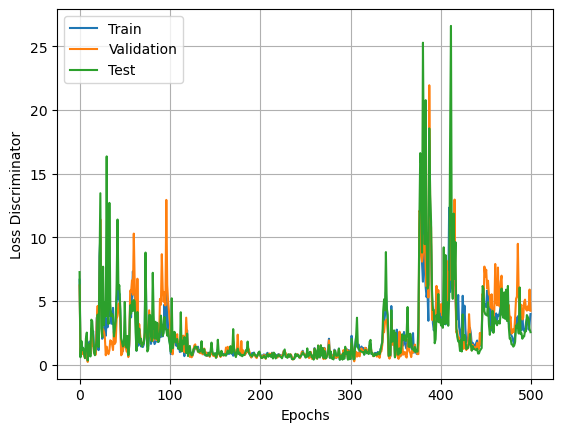

Train Loss Generator:  132.72847
Validation Loss Generator:  116.94421
Test Loss Generator 114.183914
Train Loss Discriminator:  3.9759285
Validation Discriminator:  4.2330947
Test Discriminator 2.5541396


In [15]:
loss_fn_g = Loss_G()
loss_fn_d = Loss_D()
lr = 1e-4
epochs = 500
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator, discriminator, train_loss_g, val_loss_g, test_loss_g, train_loss_d, val_loss_d, test_loss_d = train(Generator().to(device), Discriminator().to(device), loss_fn_g, loss_fn_d, lr, epochs, train_loader, val_loader, test_loader, batch_size)

# Save result images

## Train

In [16]:
i = 0
generator.eval()
for visible, ir in train_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Train_GAN/Result Fusion/"+str(i)+".png")
            visible_img.save("Train_GAN/Visible/"+str(i)+".png")
            ir_img.save("Train_GAN/IR/"+str(i)+".png")
            
            i += 1
            
            

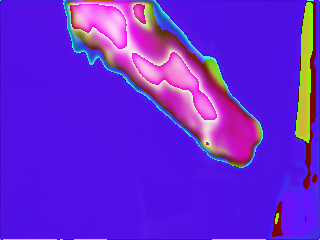

In [17]:
example_train = Image.open('Train_GAN/Result Fusion/0.png')
example_train

## Test

In [18]:
i = 0
generator.eval()
for visible, ir in test_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Test_GAN/Result Fusion/"+str(i)+".png")
            visible_img.save("Test_GAN/Visible/"+str(i)+".png")
            ir_img.save("Test_GAN/IR/"+str(i)+".png")
            
            i += 1
            
            

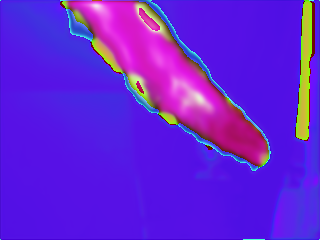

In [19]:
example_test = Image.open('Test_GAN/Result Fusion/0.png')
example_test

## Val

In [20]:
i = 0
generator.eval()
for visible, ir in val_loader:
    for j in range(len(visible)):
        visible = visible.to(device = device)
        ir = ir.to(device = device)
        with torch.no_grad():
            
            generator_input = torch.cat([visible,ir],dim = 1)
            generator_output = generator(generator_input)
            generator_output = generator_output.cpu()
            generator_output = generator_output[j].permute(1,2,0).numpy()*255
            generator_output = Image.fromarray(generator_output.astype(np.uint8), 'RGB')
            
            
            visible_img = visible.cpu()
            visible_img = visible_img[j].permute(1,2,0).numpy()*255
            visible_img = Image.fromarray(visible_img.astype(np.uint8), 'RGB')
            
            
            ir_img = ir.cpu()
            ir_img = ir_img[j].permute(1,2,0).numpy()*255
            ir_img = Image.fromarray(ir_img.astype(np.uint8), 'RGB')
            
            
            generator_output.save("Val_GAN/Result Fusion/"+str(i)+".png")
            visible_img.save("Val_GAN/Visible/"+str(i)+".png")
            ir_img.save("Val_GAN/IR/"+str(i)+".png")
            
            i += 1
            
            

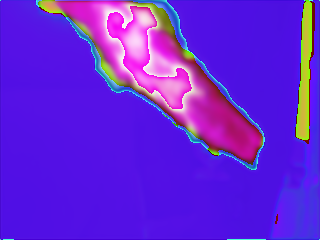

In [21]:
example_val = Image.open('Val_GAN/Result Fusion/0.png')
example_val

# Save Model

In [22]:
torch.save(generator, "Generator_Model_Checkpoint.pt")